In [43]:
import pandas as pd
import re
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import os
import joblib
import matplotlib.pyplot as plt
import json

In [44]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

file_path = r"C:\Users\yoshi\OneDrive\Desktop\CSMaster\CS439\FInalProj\legalData\legal_text_classification.csv"
df = pd.read_csv(file_path)

# Display dataset info
print("Dataset loaded:")
print(df.head())
print("Columns:", df.columns)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoshi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset loaded:
  case_id case_outcome                                         case_title  \
0   Case1        cited  Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...   
1   Case2        cited  Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...   
2   Case3        cited  Colgate Palmolive Co v Cussons Pty Ltd (1993) ...   
3   Case4        cited  Dais Studio Pty Ltd v Bullett Creative Pty Ltd...   
4   Case5        cited  Dr Martens Australia Pty Ltd v Figgins Holding...   

                                           case_text  
0  Ordinarily that discretion will be exercised s...  
1  The general principles governing the exercise ...  
2  Ordinarily that discretion will be exercised s...  
3  The general principles governing the exercise ...  
4  The preceding general principles inform the ex...  
Columns: Index(['case_id', 'case_outcome', 'case_title', 'case_text'], dtype='object')


In [45]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    return ''

df['cleaned_text'] = df['case_text'].apply(preprocess_text)
print("Preprocessed text:")
print(df[['case_text', 'cleaned_text']].head())


Preprocessed text:
                                           case_text  \
0  Ordinarily that discretion will be exercised s...   
1  The general principles governing the exercise ...   
2  Ordinarily that discretion will be exercised s...   
3  The general principles governing the exercise ...   
4  The preceding general principles inform the ex...   

                                        cleaned_text  
0  ordinarily discretion exercised cost follow ev...  
1  general principle governing exercise discretio...  
2  ordinarily discretion exercised cost follow ev...  
3  general principle governing exercise discretio...  
4  preceding general principle inform exercise di...  


In [48]:
if 'keywords' not in globals():
    keywords = {
        'family': ['children', 'custody', 'divorce', 'marriage', 'adoption', 'parenting orders', 'child support', 'spousal maintenance', 'family violence', 'guardianship', 'prenuptial agreements', 'alimony', 'domestic violence'],
        'property': ['property', 'ownership', 'land', 'real estate', 'lease', 'easements', 'mortgages', 'foreclosure', 'zoning', 'landlord', 'tenant', 'eviction', 'title deed', 'encumbrance'],
        'criminal': ['theft', 'murder', 'assault', 'fraud', 'crime', 'sentencing', 'bail', 'parole', 'prosecution', 'homicide', 'robbery', 'drug offenses', 'cybercrime', 'indictment'],
        'business': ['contract', 'agreement', 'corporation', 'partnership', 'mergers', 'franchises', 'intellectual property', 'trade practices', 'fiduciary duty', 'arbitration', 'joint venture'],
        'financial_and_securities': ['securities', 'investments', 'insider trading', 'market manipulation', 'financial services', 'hedge fund', 'derivatives', 'prospectus', 'IPO', 'compliance'],
        'administrative': ['judicial review', 'government decisions', 'statutory interpretation', 'licensing', 'zoning laws', 'public policy', 'rulemaking'],
        'employment': ['workers comp', 'workplace harassment', 'discrimination', 'severance pay', 'collective bargaining', 'wrongful termination', 'employee benefits', 'wage theft'],
        'environmental': ['pollution', 'climate change', 'conservation', 'renewable energy', 'wildlife protection', 'hazardous waste', 'emissions trading'],
        'immigration': ['visa', 'asylum', 'deportation', 'naturalization', 'green card', 'refugee status', 'work permit'],
        'tax': ['tax evasion', 'tax deduction', 'capital gains', 'estate tax', 'tax compliance', 'double taxation', 'tax treaty', 'tax audit']
    }

In [54]:
def assign_category(text):
    if not isinstance(text, str):
        return 'other'

    text = text.lower()
    category_scores = {category: 0 for category in keywords.keys()}

    for category, words in keywords.items():
        for word in words:
            category_scores[category] += text.count(word)

    max_score = max(category_scores.values())
    if max_score == 0:
        return 'other'
    return max(category_scores, key=category_scores.get)

df['case_category'] = df['cleaned_text'].apply(assign_category)
print("Initial categories assigned:")
print(df['case_category'].value_counts())

Initial categories assigned:
case_category
other                       11865
business                     5081
property                     4402
criminal                     1124
immigration                   961
administrative                595
financial_and_securities      423
family                        297
employment                    178
environmental                  55
tax                             4
Name: count, dtype: int64


Category Distribution:
case_category
other                       11865
business                     5081
property                     4402
criminal                     1124
immigration                   961
administrative                595
financial_and_securities      423
family                        297
employment                    178
environmental                  55
tax                             4
Name: count, dtype: int64


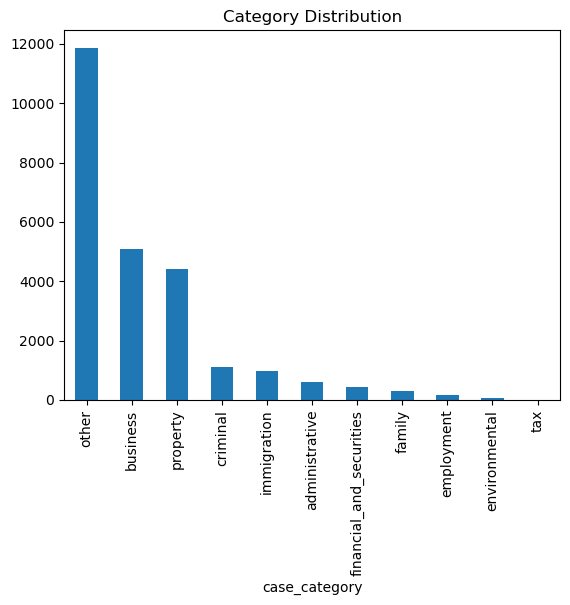

In [57]:
def evaluate_category_distribution(df):
    category_counts = df['case_category'].value_counts()
    print("Category Distribution:")
    print(category_counts)
    category_counts.plot(kind='bar', title='Category Distribution')
    plt.show()

evaluate_category_distribution(df)

In [58]:
# Combine all text for each category
category_texts = df.groupby('case_category')['cleaned_text'].apply(' '.join)

# Apply TF-IDF to find common words
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(category_texts)

# Update keywords dynamically
feature_names = tfidf.get_feature_names_out()
updated_keywords = {}

for i, category in enumerate(category_texts.index):
    print(f"Top terms for {category}:")
    sorted_indices = tfidf_matrix[i].toarray().argsort()[0][::-1]
    top_terms = [feature_names[idx] for idx in sorted_indices[:10]]
    print(top_terms)

    # Merge TF-IDF terms with existing keywords
    if category in keywords:
        updated_keywords[category] = list(set(keywords[category] + top_terms))
    else:
        updated_keywords[category] = top_terms

# Ensure all categories in the original keywords are preserved
for category in keywords:
    if category not in updated_keywords:
        updated_keywords[category] = keywords[category]

keywords = updated_keywords

# Save updated keywords to a JSON file
output_dir = 'legalData'
os.makedirs(output_dir, exist_ok=True)
keywords_file = os.path.join(output_dir, 'updated_keywords.json')
with open(keywords_file, 'w') as f:
    json.dump(keywords, f, indent=4)
print(f"Updated keywords saved to {keywords_file}")

# Resort Based on Updated Keywords
df['case_category'] = df['cleaned_text'].apply(assign_category)
print("Categories reassigned after updating keywords:")
print(df['case_category'].value_counts())

Top terms for administrative:
['court', 'decision', 'tribunal', 'act', 'minister', 'case', 'applicant', 'law', 'application', 'fact']
Top terms for business:
['court', 'document', 'privilege', 'legal', 'advice', 'act', 'case', 'party', 'pty', 'claim']
Top terms for criminal:
['court', 'act', 'case', 'mr', 'applicant', 'evidence', 'appellant', 'person', 'pty', 'tribunal']
Top terms for employment:
['act', 'applicant', 'court', 'respondent', 'case', 'tribunal', 'person', 'application', 'claim', 'conduct']
Top terms for environmental:
['clr', 'case', 'hca', 'australian', 'court', 'act', 'fcr', 'applicant', 'australia', 'proceeding']
Top terms for family:
['court', 'case', 'tribunal', 'applicant', 'act', 'document', 'order', 'mr', 'reason', 'evidence']
Top terms for financial_and_securities:
['court', 'act', 'order', 'tribunal', 'decision', 'case', 'applicant', 'application', 'time', 'pty']
Top terms for immigration:
['tribunal', 'appellant', 'applicant', 'minister', 'decision', 'court', '

Category Distribution:
case_category
environmental               3963
property                    3497
business                    3460
other                       2614
administrative              2526
immigration                 2368
employment                  1720
criminal                    1531
family                      1423
financial_and_securities    1341
tax                          542
Name: count, dtype: int64


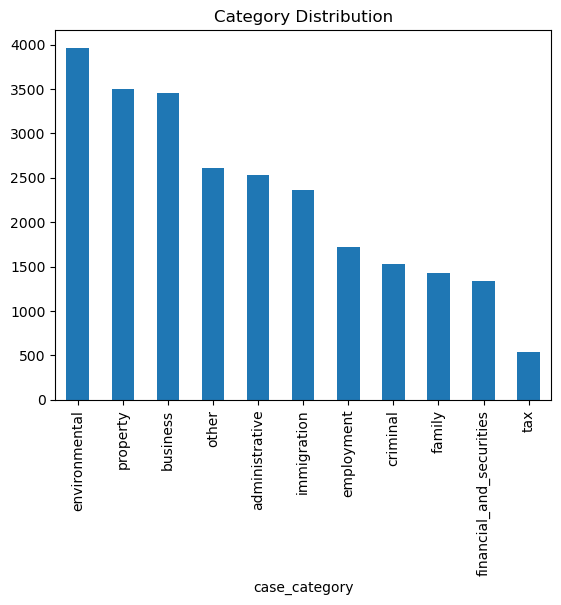

In [59]:
evaluate_category_distribution(df)

In [61]:
output_dir = 'legalData'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'cleaned_legal_text.csv')
df[['case_text', 'cleaned_text']].to_csv(output_file, index=False)
print(f"Cleaned text saved to {output_file}")

Cleaned text saved to legalData\cleaned_legal_text.csv


c:\Users\yoshi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


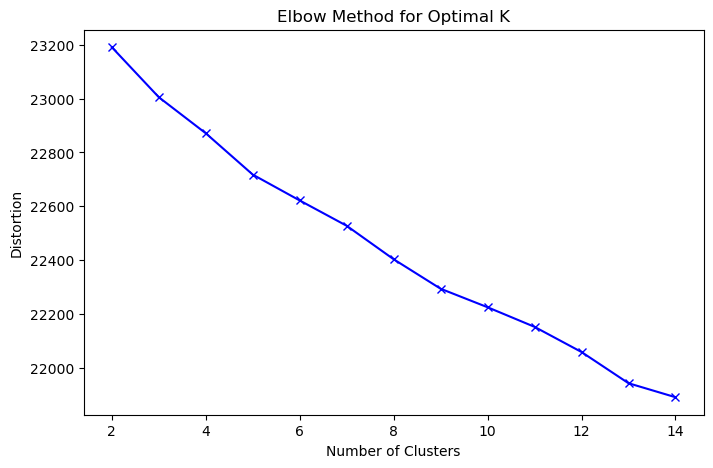

In [62]:
# STF-IDF Vectorization with n-grams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])

distortions = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=777)
    kmeans.fit(tfidf_matrix)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

# Perform Clustering with Optimal Number of Clusters
optimal_clusters = 10  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=777)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Map Clusters to Categories
cluster_to_category = {}
for cluster in range(optimal_clusters):
    cluster_docs = df[df['cluster'] == cluster]['cleaned_text']
    cluster_keywords = ' '.join(cluster_docs).split()
    category_counts = {category: sum(word in cluster_keywords for word in words) for category, words in keywords.items()}
    cluster_to_category[cluster] = max(category_counts, key=category_counts.get) if category_counts else 'other'

df['case_category'] = df['cluster'].map(cluster_to_category)


In [ ]:
calinski_harabasz = calinski_harabasz_score(tfidf_matrix.toarray(), df['cluster'])
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")

Silhouette Score: 0.02
Calinski-Harabasz Index: 176.47


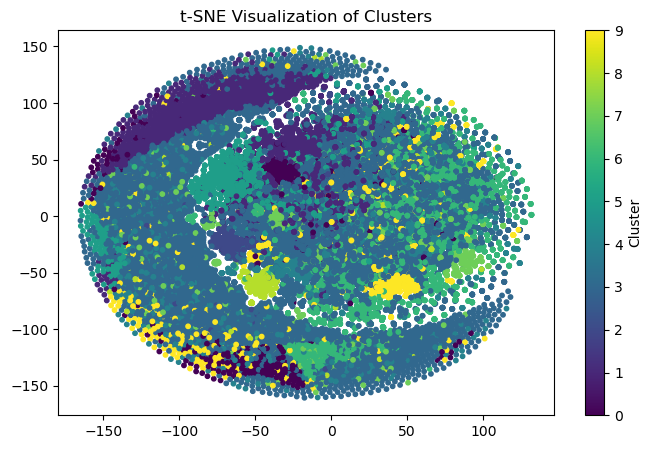

In [64]:
tsne = TSNE(n_components=2, random_state=777)
reduced_data = tsne.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(8, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'], cmap='viridis', s=10)
plt.title('t-SNE Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()

In [65]:
output_file = 'legalData/clustered_legal_text.csv'
df.to_csv(output_file, index=False)
print(f"Clustered dataset saved to {output_file}")

Clustered dataset saved to legalData/clustered_legal_text.csv
